# Code for Graph Classification

---



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# My introduction to processing and model building for molecules

While teaching myself more on graph classification with GIN architecture, I came up with issue of visualizing the molecules. As, I was't able to find the data for smiles. I dug little deeper. Some data in ogb can be found here:

https://moleculenet.org/datasets-1

This would give you a raw sample with  smile strings and target values. Some can be used for classification and some can be used for regression like mollipo which is around lipocity of a molecule. In This notebook I try to go through both classification and regression both with GIN architecture.

Will also provide how smile structures can be changed to graph data so that you can put them through a pipeline. Towards the end I would try to combine a GCN and GIN architecture to see if ensemble performs better.



In [ ]:
!pip install rdkit

In [ ]:
#!/bin/sh
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-2.2.1+cu121.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-2.2.1+cu121.html
!pip install torch-geometric
!pip install ogb

In [90]:

import os
import argparse
import pickle
import torch
import torch_geometric
from torch_geometric.nn import GINConv, global_add_pool,GCNConv
from torch_geometric.loader import DataLoader
from torch_geometric.nn.models import MLP
from ogb.graphproppred import PygGraphPropPredDataset, Evaluator
from ogb.graphproppred.mol_encoder import AtomEncoder
import pandas as pd
import copy
import numpy as np
import random
from tqdm import tqdm

In [5]:

hiv_data = pd.read_csv("/content/drive/MyDrive/HIV.csv")

lipo_data = pd.read_csv("/content/drive/MyDrive/Lipophilicity.csv")

In [6]:
hiv_data.head(4)

,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0


In [7]:
lipo_data.head(4)

,CMPD_CHEMBLID,exp,smiles
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...


In [8]:
hiv_data['activity'].unique() ## clinically active(CA), clinically inactive(CI),mildly clinically active(CM)

array(['CI', 'CM', 'CA'], dtype=object)

In [10]:
hiv_data[hiv_data['activity'] == "CA"]

,smiles,activity,HIV_active
271,Cc1cc(-c2ccc(N=Nc3cc(S(=O)(=O)O)c4ccccc4c3N)c(...,CA,1
352,O=S(=O)(O)c1cc2ccc1ccc1ccc(cc1S(=O)(=O)O)nnc1c...,CA,1
353,Nc1c(N=Nc2ccc(-c3ccc(N=Nc4cc(S(=O)(=O)O)c5cccc...,CA,1
429,COC1C(OC(=O)C=CC=CC=CC=CC(=O)O)CCC2(CO2)C1C1(C...,CA,1
443,COc1cc(-c2ccc(N=Nc3ccc4c(S(=O)(=O)O)cc(S(=O)(=...,CA,1
...,...,...,...
41029,CCCCCCCCCCCCCCCCCCOC(COP(=O)(O)OCC1CCC(n2cnc3c...,CA,1
41031,CCCCCCCCCCCCCCCC(=O)Nc1ccn(C2CCC(COP(=O)(O)OCC...,CA,1
41054,CCN1CC(C)Cn2c(=S)[nH]c3cc(Br)cc1c32,CA,1
41055,CCN1c2cc(Br)cc3[nH]c(=S)n(c23)CCC1C,CA,1


                                              smiles activity  HIV_active
0  CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...       CI           0
1  C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...       CI           0
2                   CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21       CI           0
3    Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1       CI           0


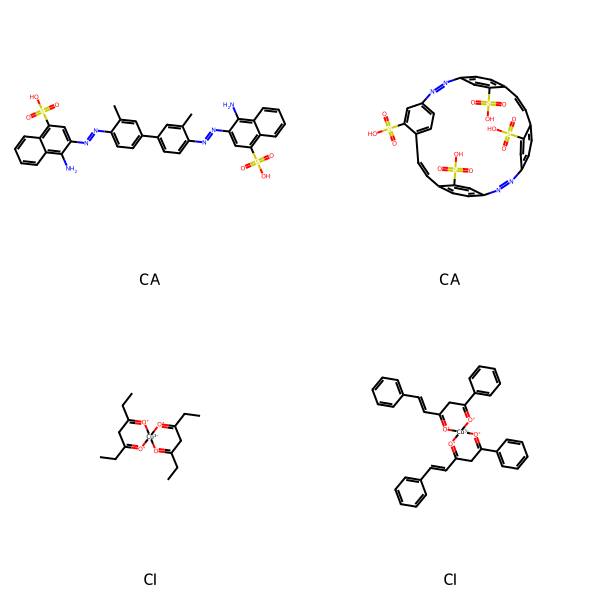

In [28]:
from rdkit import Chem
from rdkit.Chem import Draw

# Sample SMILES data
c_active = hiv_data[hiv_data['activity'] =="CA"]
c_inactive = hiv_data[hiv_data['activity'] =="CI"]


smiles_data = list(c_active['smiles'].head(2)) + list(c_inactive['smiles'].head(2))
activity_data = list(c_active['activity'].head(2)) + list(c_inactive['activity'].head(2))

# Convert SMILES to RDKit Molecule objects
molecules = [Chem.MolFromSmiles(smiles) for smiles in smiles_data]

# Display molecules in a grid
img = Draw.MolsToGridImage(molecules, molsPerRow=2, subImgSize=(300, 300), legends=activity_data, maxMols=4)
print(hiv_data.iloc[0:4,])
img

# How do you go about implementing this data in Graph Neural Network?

Processed data is available with OGB(Open Graph Benchmark) package. Which contains large database related to graph structures. In case you have your own data you can use the following function to change your SMILE molecule string to graph data for Pytorch_geometric format.



In [29]:
smiles_data

['Cc1cc(-c2ccc(N=Nc3cc(S(=O)(=O)O)c4ccccc4c3N)c(C)c2)ccc1N=Nc1cc(S(=O)(=O)O)c2ccccc2c1N',
 'O=S(=O)(O)c1cc2ccc1ccc1ccc(cc1S(=O)(=O)O)nnc1ccc(ccc3ccc(cc3S(=O)(=O)O)nn2)c(S(=O)(=O)O)c1',
 'CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)=[O+]2',
 'C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3)CC(c3ccccc3)=[O+]2)[O+]=C(c2ccccc2)C1']

In [30]:
from ogb.utils.mol import smiles2graph
graph_data_sample = smiles2graph(smiles_data[0])




In [31]:
graph_data_sample

{'edge_index': array([[ 0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,
          8,  9,  9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 13, 15, 13, 16,
         12, 17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24,
          7, 25, 25, 26, 25, 27,  3, 28, 28, 29, 29, 30, 30, 31, 31, 32,
         32, 33, 33, 34, 34, 35, 35, 36, 36, 37, 36, 38, 36, 39, 35, 40,
         40, 41, 41, 42, 42, 43, 43, 44, 44, 45, 45, 46, 46, 47, 30,  1,
         46, 33, 27,  4, 45, 40, 23, 10, 22, 17],
        [ 1,  0,  2,  1,  3,  2,  4,  3,  5,  4,  6,  5,  7,  6,  8,  7,
          9,  8, 10,  9, 11, 10, 12, 11, 13, 12, 14, 13, 15, 13, 16, 13,
         17, 12, 18, 17, 19, 18, 20, 19, 21, 20, 22, 21, 23, 22, 24, 23,
         25,  7, 26, 25, 27, 25, 28,  3, 29, 28, 30, 29, 31, 30, 32, 31,
         33, 32, 34, 33, 35, 34, 36, 35, 37, 36, 38, 36, 39, 36, 40, 35,
         41, 40, 42, 41, 43, 42, 44, 43, 45, 44, 46, 45, 47, 46,  1, 30,
         33, 46,  4, 27, 40, 45, 10, 23, 17, 22]]),
 'edge_f

In [33]:
graph_data_sample.keys()

dict_keys(['edge_index', 'edge_feat', 'node_feat', 'num_nodes'])

In [35]:
from ogb.graphproppred import PygGraphPropPredDataset

# Load the dataset
dataset = PygGraphPropPredDataset(name="ogbg-molhiv")
# Get a sample (e.g., the first sample)
sample = dataset[0]

/usr/local/lib/python3.10/dist-packages/ogb/graphproppred/dataset_pyg.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed

As you can see below the sample from the OGB package, has same variables with an additional variable y. Which is our target variable. If you are preprocessing from raw data that is Smile stucture to a label.

You can process the data then change the names

from dict_keys(['edge_index', 'edge_feat', 'node_feat', 'num_nodes'])

to edge_index=[2, 40], edge_attr=[40, 3], x=[19, 9], y=[1, 1], num_nodes=19

Here edge_index remains same, edge_feat -> edge_attr, node_feat -> x, hiv_data['HIV_active'] -> y and num_nodes remains same.

** With this you would be able to process any SMILE molecule with a label and build your own pipeline for molecule classifier or property prediction(Later on with ogb-mollipo data).**


In [40]:
# Get a sample (e.g., the first sample)

# Print sample details
print("Sample Graph:", sample)
print("Node features (x):", sample.x)
print("Edge index (connectivity):", sample.edge_index)
print("Graph label (y):", sample.y)

Sample Graph: Data(edge_index=[2, 40], edge_attr=[40, 3], x=[19, 9], y=[1, 1], num_nodes=19)
Node features (x): tensor([[ 5,  0,  4,  5,  3,  0,  2,  0,  0],
        [ 5,  0,  4,  5,  2,  0,  2,  0,  0],
        [ 5,  0,  3,  5,  0,  0,  1,  0,  1],
        [ 7,  0,  2,  6,  0,  0,  1,  0,  1],
        [28,  0,  4,  2,  0,  0,  5,  0,  1],
        [ 7,  0,  2,  6,  0,  0,  1,  0,  1],
        [ 5,  0,  3,  5,  0,  0,  1,  0,  1],
        [ 5,  0,  4,  5,  2,  0,  2,  0,  0],
        [ 5,  0,  4,  5,  3,  0,  2,  0,  0],
        [ 5,  0,  4,  5,  2,  0,  2,  0,  1],
        [ 7,  0,  2,  6,  0,  0,  1,  0,  1],
        [ 5,  0,  3,  5,  0,  0,  1,  0,  1],
        [ 5,  0,  4,  5,  2,  0,  2,  0,  0],
        [ 5,  0,  4,  5,  3,  0,  2,  0,  0],
        [ 5,  0,  4,  5,  2,  0,  2,  0,  1],
        [ 5,  0,  3,  5,  0,  0,  1,  0,  1],
        [ 5,  0,  4,  5,  2,  0,  2,  0,  0],
        [ 5,  0,  4,  5,  3,  0,  2,  0,  0],
        [ 7,  0,  2,  6,  0,  0,  1,  0,  1]])
Edge index (c

Data(edge_index=[2, 40], edge_attr=[40, 3], x=[19, 9], y=[1, 1], num_nodes=19)

In [46]:
# Let's set a random seed for reproducibility
# -------------------------------------------
# If using a GPU choosing the same seed cannot be used to guarantee
# that one gets the same result from run to run,
# but may still be useful to ensure one is starting with different seeds.
def set_seeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [47]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# set_seeds(args.random_seed)

In [48]:
set_seeds(34)

In [106]:
config = {
 'device': 'cuda',
 'dataset_id': 'ogbg-molhiv',
 'num_layers': 2,
 'hidden_dim': 64,
 'dropout': 0.5,
 'learning_rate': 0.001,
 'epochs': 25,
 'batch_size': 32,
 'weight_decay': 1e-6
}

In [49]:
# dataset loading
dataset = PygGraphPropPredDataset(name=config["dataset_id"], transform=None)

/usr/local/lib/python3.10/dist-packages/ogb/graphproppred/dataset_pyg.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed

In [50]:
evaluator = Evaluator(name=config["dataset_id"])
split_idx = dataset.get_idx_split()

train_loader = DataLoader(dataset[split_idx["train"]], batch_size=config["batch_size"], shuffle=True)
valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=config["batch_size"], shuffle=False)
test_loader = None

# Why use batching in here?

Batching is common in neural network architecture. Why is that? cause it helps better memory allocation, you don't have to load all the data instead can load in batchs. It also smooths out the gradient calculation. There are other reasons too but I like to keep it short :)

In [51]:
for i, batch in enumerate(train_loader):
    print(f' - Batch {i}: {batch}')

print('\nValidation loader:')
for i, batch in enumerate(valid_loader):
    print(f' - Batch {i}: {batch}')


## train set has 1028 batchs
## validation set has 128 batchs

 - Batch 0: DataBatch(edge_index=[2, 1744], edge_attr=[1744, 3], x=[814, 9], y=[32, 1], num_nodes=814, batch=[814], ptr=[33])
 - Batch 1: DataBatch(edge_index=[2, 1636], edge_attr=[1636, 3], x=[759, 9], y=[32, 1], num_nodes=759, batch=[759], ptr=[33])
 - Batch 2: DataBatch(edge_index=[2, 1594], edge_attr=[1594, 3], x=[749, 9], y=[32, 1], num_nodes=749, batch=[749], ptr=[33])
 - Batch 3: DataBatch(edge_index=[2, 1704], edge_attr=[1704, 3], x=[806, 9], y=[32, 1], num_nodes=806, batch=[806], ptr=[33])
 - Batch 4: DataBatch(edge_index=[2, 1576], edge_attr=[1576, 3], x=[747, 9], y=[32, 1], num_nodes=747, batch=[747], ptr=[33])
 - Batch 5: DataBatch(edge_index=[2, 1708], edge_attr=[1708, 3], x=[799, 9], y=[32, 1], num_nodes=799, batch=[799], ptr=[33])
 - Batch 6: DataBatch(edge_index=[2, 1860], edge_attr=[1860, 3], x=[865, 9], y=[32, 1], num_nodes=865, batch=[865], ptr=[33])
 - Batch 7: DataBatch(edge_index=[2, 1798], edge_attr=[1798, 3], x=[842, 9], y=[32, 1], num_nodes=842, batch=[842], pt

In [94]:
## architecture from stanford project by william bruns
# computes a node embedding using GINConv layers, then uses pooling to predict graph level properties
class GINGraphPropertyModel(torch.nn.Module):
    def __init__(self, hidden_dim, output_dim, num_layers, dropout_p):
      super(GINGraphPropertyModel, self).__init__()
      # fields used for computing node embedding
      self.node_encoder = AtomEncoder(hidden_dim)

      self.convs = torch.nn.ModuleList(
          [torch_geometric.nn.conv.GINConv(MLP([hidden_dim, hidden_dim, hidden_dim])) for idx in range(0, num_layers)]
      )
      self.bns = torch.nn.ModuleList(
          [torch.nn.BatchNorm1d(num_features = hidden_dim) for idx in range(0, num_layers - 1)]
      )
      self.dropout_p = dropout_p
      # end fields used for computing node embedding
      # fields for graph embedding
      self.pool = global_add_pool
      self.linear_hidden = torch.nn.Linear(hidden_dim, hidden_dim)
      self.linear_out = torch.nn.Linear(hidden_dim, output_dim)
      # end fields for graph embedding
    def reset_parameters(self):
      for conv in self.convs:
        conv.reset_parameters()
      for bn in self.bns:
        bn.reset_parameters()
      self.linear_hidden.reset_parameters()
      self.linear_out.reset_parameters()
    def forward(self, batched_data):
      x, edge_index, batch = batched_data.x, batched_data.edge_index, batched_data.batch
      # compute node embedding
      x = self.node_encoder(x)
      for idx in range(0, len(self.convs)):
        x = self.convs[idx](x, edge_index)
        if idx < len(self.convs) - 1:
          x = self.bns[idx](x)
          x = torch.nn.functional.relu(x)
          x = torch.nn.functional.dropout(x, self.dropout_p, training=self.training)
      # note x is raw logits, NOT softmax'd
      # end computation of node embedding
      # convert node embedding to a graph level embedding using pooling
      x = self.pool(x, batch)
      x = torch.nn.functional.dropout(x, self.dropout_p, training=self.training)
      # transform the graph embedding to the output dimension
      # MLP after graph embed ensures we are not requiring the raw pooled node embeddings to be linearly separable
      x = self.linear_hidden(x)
      x = torch.nn.functional.relu(x)
      x = torch.nn.functional.dropout(x, self.dropout_p, training=self.training)
      out = self.linear_out(x)
      return out

In [95]:


# computes a node embedding using GCN layers, then uses pooling to predict graph level properties
class GCNGraphPropertyModel(torch.nn.Module):
    def __init__(self, hidden_dim, output_dim, num_layers, dropout_p):
      super(GCNGraphPropertyModel, self).__init__()
      # fields used for computing node embedding
      self.node_encoder = AtomEncoder(hidden_dim)

      self.convs = torch.nn.ModuleList(
          [GCNConv(hidden_dim, hidden_dim) for _ in range(num_layers)]
      )
      self.bns = torch.nn.ModuleList(
          [torch.nn.BatchNorm1d(num_features = hidden_dim) for idx in range(0, num_layers - 1)]
      )
      self.dropout_p = dropout_p
      # end fields used for computing node embedding
      # fields for graph embedding
      self.pool = global_add_pool
      self.linear_hidden = torch.nn.Linear(hidden_dim, hidden_dim)
      self.linear_out = torch.nn.Linear(hidden_dim, output_dim)
      # end fields for graph embedding
    def reset_parameters(self):
      for conv in self.convs:
        conv.reset_parameters()
      for bn in self.bns:
        bn.reset_parameters()
      self.linear_hidden.reset_parameters()
      self.linear_out.reset_parameters()
    def forward(self, batched_data):
      x, edge_index, batch = batched_data.x, batched_data.edge_index, batched_data.batch
      # compute node embedding
      x = self.node_encoder(x)
      for idx in range(0, len(self.convs)):
        x = self.convs[idx](x, edge_index)
        if idx < len(self.convs) - 1:
          x = self.bns[idx](x)
          x = torch.nn.functional.relu(x)
          x = torch.nn.functional.dropout(x, self.dropout_p, training=self.training)
      # note x is raw logits, NOT softmax'd
      # end computation of node embedding
      # convert node embedding to a graph level embedding using pooling
      x = self.pool(x, batch)
      x = torch.nn.functional.dropout(x, self.dropout_p, training=self.training)
      # transform the graph embedding to the output dimension
      # MLP after graph embed ensures we are not requiring the raw pooled node embeddings to be linearly separable
      x = self.linear_hidden(x)
      x = torch.nn.functional.relu(x)
      x = torch.nn.functional.dropout(x, self.dropout_p, training=self.training)
      out = self.linear_out(x)
      return out

In [118]:
# can be used with multiple task outputs (like for molpcba) or single task output;
# and supports using just the first output of a multi-task model if applied to a single task (for pretraining molpcba and transferring to molhiv)
def train(model, device, data_loader, optimizer, loss_fn):
  model.train()
  for step, batch in enumerate(tqdm(data_loader, desc="Training batch")):
    batch = batch.to(device)
    if batch.x.shape[0] != 1 and batch.batch[-1] != 0:
      # ignore nan targets (unlabeled) when computing training loss.
      non_nan = batch.y == batch.y
      loss = None
      optimizer.zero_grad()
      out = model(batch)
      non_nan = non_nan[:min(non_nan.shape[0], out.shape[0])]
      batch_y = batch.y[:out.shape[0], :]
      # for crudely adapting multitask models to single task data
      if batch.y.shape[1] == 1:
        out = out[:, 0]
        batch_y = batch_y[:, 0]
        non_nan = batch_y == batch_y
        loss = loss_fn(out[non_nan].reshape(-1, 1)*1., batch_y[non_nan].reshape(-1, 1)*1.)
      else:
        loss = loss_fn(out[non_nan], batch_y[non_nan])
      loss.backward()
      optimizer.step()
  return loss.item()

def eval(model, device, loader, evaluator, save_model_results=False, save_filename=None):
  model.eval()
  y_true = []
  y_pred = []
  for step, batch in enumerate(tqdm(loader, desc="Evaluation batch")):
      batch = batch.to(device)
      if batch.x.shape[0] == 1:
          pass
      else:
          with torch.no_grad():
              pred = model(batch)
              # for crudely adapting multitask models to single task data
              if batch.y.shape[1] == 1:
                pred = pred[:, 0]
              batch_y = batch.y[:min(pred.shape[0], batch.y.shape[0])]
              y_true.append(batch_y.view(pred.shape).detach().cpu())
              y_pred.append(pred.detach().cpu())
  y_true = torch.cat(y_true, dim=0).numpy()
  y_pred = torch.cat(y_pred, dim=0).numpy()
  input_dict = {"y_true": y_true.reshape(-1, 1) if batch.y.shape[1] == 1 else y_true, "y_pred": y_pred.reshape(-1, 1) if batch.y.shape[1] == 1 else y_pred}
  if save_model_results:
      single_task = len(y_true.shape) == 1 or y_true.shape[1] == 1
      if single_task:
          data = {
              'y_pred': y_pred.squeeze(),
              'y_true': y_true.squeeze()
          }
          pd.DataFrame(data=data).to_csv('ogbg_graph_' + save_filename + '.csv', sep=',', index=False)
      else:
          num_tasks = y_true.shape[1]
          for task_idx in range(num_tasks):
              data = {
                  'y_pred': y_pred[:, task_idx].squeeze(),
                  'y_true': y_true[:, task_idx].squeeze()
              }
              pd.DataFrame(data=data).to_csv('ogbg_graph_' + save_filename + f'_task_{task_idx}.csv', sep=',', index=False)
  return evaluator.eval(input_dict)

def combined_eval(gin_model, gcn_model, device, loader, evaluator):
    gin_model.eval()
    gcn_model.eval()

    y_true = []
    y_pred = []

    for step, batch in enumerate(tqdm(loader, desc="Evaluation batch")):
      batch = batch.to(device)
      if batch.x.shape[0] == 1:
        pass
      else:
        with torch.no_grad():
          pred1 = gin_model(batch)
          pred2 = gcn_model(batch)
          pred = (pred1 + pred2) / 2

          if batch.y.shape[1] == 1:
            pred = pred[:, 0]
          batch_y = batch.y[:min(pred.shape[0], batch.y.shape[0])]
          y_true.append(batch_y.view(pred.shape).detach().cpu())
          y_pred.append(pred.detach().cpu())

    y_true = torch.cat(y_true, dim=0).numpy()
    y_pred = torch.cat(y_pred, dim=0).numpy()
    input_dict = {"y_true": y_true.reshape(-1, 1) if batch.y.shape[1] == 1 else y_true, "y_pred": y_pred.reshape(-1, 1) if batch.y.shape[1] == 1 else y_pred}
    # if save_model_results:
    #     single_task = len(y_true.shape) == 1 or y_true.shape[1] == 1
    #     if single_task:
    #         data = {
    #             'y_pred': y_pred.squeeze(),
    #             'y_true': y_true.squeeze()
    #         }
    #         pd.DataFrame(data=data).to_csv('ogbg_graph_' + save_filename + '.csv', sep=',', index=False)
    #     else:
    #         num_tasks = y_true.shape[1]
    #         for task_idx in range(num_tasks):
    #             data = {
    #                 'y_pred': y_pred[:, task_idx].squeeze(),
    #                 'y_true': y_true[:, task_idx].squeeze()
    #             }
    #             pd.DataFrame(data=data).to_csv('ogbg_graph_' + save_filename + f'_task_{task_idx}.csv', sep=',', index=False)
    return evaluator.eval(input_dict)


# Run combined evaluation on the validation set
# combined_val_performance = combined_eval(gin_model, gcn_model, device, valid_loader, evaluator)
# print("Combined Validation Performance:", combined_val_performance)



In [107]:

model2 = GCNGraphPropertyModel(config['hidden_dim'], dataset.num_tasks, config['num_layers'], config['dropout']).to(device)
print(f"parameter count: {sum(p.numel() for p in model2.parameters())}")
model2.reset_parameters()

optimizer = torch.optim.Adam(model2.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
loss_fn = torch.nn.BCEWithLogitsLoss()
best_model2 = None
best_valid_metric_at_save_checkpoint = 0
best_train_metric_at_save_checkpoint = 0

for epoch in range(1, 1 + config["epochs"]):
  if epoch == 10:
    # reduce learning rate at this point
    optimizer = torch.optim.Adam(model2.parameters(), lr=config['learning_rate']*0.5, weight_decay=config['weight_decay'])
  loss = train(model2, device, train_loader, optimizer, loss_fn)
  train_perf = eval(model2, device, train_loader, evaluator)
  val_perf = eval(model2, device, valid_loader, evaluator)

  train_metric, valid_metric = train_perf[dataset.eval_metric], val_perf[dataset.eval_metric]
  if valid_metric >= best_valid_metric_at_save_checkpoint and train_metric >= best_train_metric_at_save_checkpoint:
    print(f"New best validation score: {valid_metric} ({dataset.eval_metric}) without training score regression")
    best_valid_metric_at_save_checkpoint = valid_metric
    best_train_metric_at_save_checkpoint = train_metric
    best_model2 = copy.deepcopy(model2)
  print(f'Dataset {config["dataset_id"]}, ',
    f'Epoch: {epoch}, ',
    f'Train: {train_metric:.6f} ({dataset.eval_metric}), ',
    f'Valid: {valid_metric:.6f} ({dataset.eval_metric}), ')

with open(f"best_{config['dataset_id']}_gcn_model_{config['num_layers']}_layers_{config['hidden_dim']}_hidden.pkl", "wb") as f:
  pickle.dump(best_model2, f)

train_metric = eval(best_model2, device, train_loader, evaluator)[dataset.eval_metric]
valid_metric = eval(best_model2, device, valid_loader, evaluator, save_model_results=True, save_filename=f"gcn_{config['dataset_id']}_valid")[dataset.eval_metric]
test_metric = None

print(f'Best model for {config["dataset_id"]} (eval metric {dataset.eval_metric}): ',
      f'Train: {train_metric:.6f}, ',
      f'Valid: {valid_metric:.6f} ')
print(f"parameter count: {sum(p.numel() for p in best_model.parameters())}")

parameter count: 23809


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 209.10it/s]


New best validation score: 0.5548176317852244 (rocauc) without training score regression
Dataset ogbg-molhiv,  Epoch: 1,  Train: 0.575244 (rocauc),  Valid: 0.554818 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 204.15it/s]


New best validation score: 0.5916709533607682 (rocauc) without training score regression
Dataset ogbg-molhiv,  Epoch: 2,  Train: 0.622812 (rocauc),  Valid: 0.591671 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 212.41it/s]


New best validation score: 0.6083951842053694 (rocauc) without training score regression
Dataset ogbg-molhiv,  Epoch: 3,  Train: 0.675794 (rocauc),  Valid: 0.608395 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 206.40it/s]


New best validation score: 0.635603444052518 (rocauc) without training score regression
Dataset ogbg-molhiv,  Epoch: 4,  Train: 0.678607 (rocauc),  Valid: 0.635603 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 209.81it/s]


New best validation score: 0.6478205222418185 (rocauc) without training score regression
Dataset ogbg-molhiv,  Epoch: 5,  Train: 0.736403 (rocauc),  Valid: 0.647821 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 210.82it/s]


Dataset ogbg-molhiv,  Epoch: 6,  Train: 0.732728 (rocauc),  Valid: 0.717755 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 204.92it/s]


Dataset ogbg-molhiv,  Epoch: 7,  Train: 0.735490 (rocauc),  Valid: 0.735831 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 214.59it/s]


Dataset ogbg-molhiv,  Epoch: 8,  Train: 0.716193 (rocauc),  Valid: 0.681780 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 209.63it/s]


New best validation score: 0.7322194052518127 (rocauc) without training score regression
Dataset ogbg-molhiv,  Epoch: 9,  Train: 0.755528 (rocauc),  Valid: 0.732219 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 211.78it/s]


New best validation score: 0.7439894424848129 (rocauc) without training score regression
Dataset ogbg-molhiv,  Epoch: 10,  Train: 0.757519 (rocauc),  Valid: 0.743989 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 209.44it/s]


Dataset ogbg-molhiv,  Epoch: 11,  Train: 0.768113 (rocauc),  Valid: 0.742786 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 213.56it/s]


Dataset ogbg-molhiv,  Epoch: 12,  Train: 0.761898 (rocauc),  Valid: 0.722051 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 212.28it/s]


Dataset ogbg-molhiv,  Epoch: 13,  Train: 0.766882 (rocauc),  Valid: 0.734788 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 211.40it/s]


New best validation score: 0.7657046100333138 (rocauc) without training score regression
Dataset ogbg-molhiv,  Epoch: 14,  Train: 0.764440 (rocauc),  Valid: 0.765705 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 210.82it/s]


Dataset ogbg-molhiv,  Epoch: 15,  Train: 0.772671 (rocauc),  Valid: 0.748321 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 212.60it/s]


Dataset ogbg-molhiv,  Epoch: 16,  Train: 0.774685 (rocauc),  Valid: 0.752315 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 210.21it/s]


Dataset ogbg-molhiv,  Epoch: 17,  Train: 0.766932 (rocauc),  Valid: 0.717657 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 213.30it/s]


Dataset ogbg-molhiv,  Epoch: 18,  Train: 0.778308 (rocauc),  Valid: 0.748954 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 215.44it/s]


Dataset ogbg-molhiv,  Epoch: 19,  Train: 0.775067 (rocauc),  Valid: 0.756510 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 211.65it/s]


Dataset ogbg-molhiv,  Epoch: 20,  Train: 0.780727 (rocauc),  Valid: 0.733986 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 214.54it/s]


Dataset ogbg-molhiv,  Epoch: 21,  Train: 0.775274 (rocauc),  Valid: 0.751251 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 210.69it/s]


Dataset ogbg-molhiv,  Epoch: 22,  Train: 0.782036 (rocauc),  Valid: 0.751828 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 212.58it/s]


Dataset ogbg-molhiv,  Epoch: 23,  Train: 0.785038 (rocauc),  Valid: 0.750248 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 202.24it/s]


Dataset ogbg-molhiv,  Epoch: 24,  Train: 0.784143 (rocauc),  Valid: 0.760482 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 210.32it/s]


Dataset ogbg-molhiv,  Epoch: 25,  Train: 0.783329 (rocauc),  Valid: 0.746248 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 182.38it/s]

Best model for ogbg-molhiv (eval metric rocauc):  Train: 0.764440,  Valid: 0.765705 
parameter count: 23809


GCN based model performance

Train: 0.76

Validation set: 0.76

In [113]:

model = GINGraphPropertyModel(config['hidden_dim'], dataset.num_tasks, config['num_layers'], config['dropout']).to(device)
print(f"parameter count: {sum(p.numel() for p in model.parameters())}")
model.reset_parameters()

optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
loss_fn = torch.nn.BCEWithLogitsLoss()
best_model = None
best_valid_metric_at_save_checkpoint = 0
best_train_metric_at_save_checkpoint = 0

for epoch in range(1, 1 + config["epochs"]):
  if epoch == 10:
    # reduce learning rate at this point
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate']*0.5, weight_decay=config['weight_decay'])
  loss = train(model, device, train_loader, optimizer, loss_fn)
  train_perf = eval(model, device, train_loader, evaluator)
  val_perf = eval(model, device, valid_loader, evaluator)
  # if not args.hide_test_metric:
  #     # not necessary as output unused during train loop but needed for reproduciblility as affects number of random number generations, affecting ability to generate previously observed outputs depending on seed
  #     test_perf = eval(model, device, test_loader, evaluator)
  train_metric, valid_metric = train_perf[dataset.eval_metric], val_perf[dataset.eval_metric]
  if valid_metric >= best_valid_metric_at_save_checkpoint and train_metric >= best_train_metric_at_save_checkpoint:
    print(f"New best validation score: {valid_metric} ({dataset.eval_metric}) without training score regression")
    best_valid_metric_at_save_checkpoint = valid_metric
    best_train_metric_at_save_checkpoint = train_metric
    best_model = copy.deepcopy(model)
  print(f'Dataset {config["dataset_id"]}, ',
    f'Epoch: {epoch}, ',
    f'Train: {train_metric:.6f} ({dataset.eval_metric}), ',
    f'Valid: {valid_metric:.6f} ({dataset.eval_metric}), ')

with open(f"best_{config['dataset_id']}_gin_model_{config['num_layers']}_layers_{config['hidden_dim']}_hidden.pkl", "wb") as f:
  pickle.dump(best_model, f)

train_metric = eval(best_model, device, train_loader, evaluator)[dataset.eval_metric]
valid_metric = eval(best_model, device, valid_loader, evaluator, save_model_results=True, save_filename=f"gin_{config['dataset_id']}_valid")[dataset.eval_metric]
test_metric = None

print(f'Best model for {config["dataset_id"]} (eval metric {dataset.eval_metric}): ',
      f'Train: {train_metric:.6f}, ',
      f'Valid: {valid_metric:.6f} ')
print(f"parameter count: {sum(p.numel() for p in best_model.parameters())}")

parameter count: 32385


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 234.06it/s]


New best validation score: 0.6264666617675877 (rocauc) without training score regression
Dataset ogbg-molhiv,  Epoch: 1,  Train: 0.646297 (rocauc),  Valid: 0.626467 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 235.55it/s]


New best validation score: 0.693259479717813 (rocauc) without training score regression
Dataset ogbg-molhiv,  Epoch: 2,  Train: 0.712402 (rocauc),  Valid: 0.693259 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 232.77it/s]


Dataset ogbg-molhiv,  Epoch: 3,  Train: 0.728549 (rocauc),  Valid: 0.684564 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 235.83it/s]


New best validation score: 0.6945914168136391 (rocauc) without training score regression
Dataset ogbg-molhiv,  Epoch: 4,  Train: 0.749483 (rocauc),  Valid: 0.694591 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 233.46it/s]


Dataset ogbg-molhiv,  Epoch: 5,  Train: 0.742775 (rocauc),  Valid: 0.675323 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 237.02it/s]


New best validation score: 0.7170567558299039 (rocauc) without training score regression
Dataset ogbg-molhiv,  Epoch: 6,  Train: 0.761924 (rocauc),  Valid: 0.717057 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 233.33it/s]


Dataset ogbg-molhiv,  Epoch: 7,  Train: 0.771187 (rocauc),  Valid: 0.702363 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 233.35it/s]


Dataset ogbg-molhiv,  Epoch: 8,  Train: 0.772307 (rocauc),  Valid: 0.686695 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 239.72it/s]


Dataset ogbg-molhiv,  Epoch: 9,  Train: 0.765707 (rocauc),  Valid: 0.699227 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 236.28it/s]


New best validation score: 0.7390444346462864 (rocauc) without training score regression
Dataset ogbg-molhiv,  Epoch: 10,  Train: 0.799679 (rocauc),  Valid: 0.739044 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 229.70it/s]


New best validation score: 0.7420236870468352 (rocauc) without training score regression
Dataset ogbg-molhiv,  Epoch: 11,  Train: 0.804708 (rocauc),  Valid: 0.742024 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 237.09it/s]


Dataset ogbg-molhiv,  Epoch: 12,  Train: 0.787088 (rocauc),  Valid: 0.650895 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 236.46it/s]


Dataset ogbg-molhiv,  Epoch: 13,  Train: 0.800515 (rocauc),  Valid: 0.712795 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 237.90it/s]


Dataset ogbg-molhiv,  Epoch: 14,  Train: 0.805816 (rocauc),  Valid: 0.731561 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 235.06it/s]


New best validation score: 0.7472901969429747 (rocauc) without training score regression
Dataset ogbg-molhiv,  Epoch: 15,  Train: 0.813371 (rocauc),  Valid: 0.747290 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 240.40it/s]


Dataset ogbg-molhiv,  Epoch: 16,  Train: 0.819615 (rocauc),  Valid: 0.744139 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 241.06it/s]


New best validation score: 0.7482684817754262 (rocauc) without training score regression
Dataset ogbg-molhiv,  Epoch: 17,  Train: 0.823940 (rocauc),  Valid: 0.748268 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 238.01it/s]


Dataset ogbg-molhiv,  Epoch: 18,  Train: 0.815255 (rocauc),  Valid: 0.734306 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 237.16it/s]


Dataset ogbg-molhiv,  Epoch: 19,  Train: 0.827688 (rocauc),  Valid: 0.732296 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 216.03it/s]


Dataset ogbg-molhiv,  Epoch: 20,  Train: 0.827987 (rocauc),  Valid: 0.707568 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 234.77it/s]


Dataset ogbg-molhiv,  Epoch: 21,  Train: 0.824101 (rocauc),  Valid: 0.735055 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 235.23it/s]


Dataset ogbg-molhiv,  Epoch: 22,  Train: 0.835729 (rocauc),  Valid: 0.709111 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 232.24it/s]


Dataset ogbg-molhiv,  Epoch: 23,  Train: 0.836447 (rocauc),  Valid: 0.721670 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 239.43it/s]


Dataset ogbg-molhiv,  Epoch: 24,  Train: 0.834769 (rocauc),  Valid: 0.738968 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 236.94it/s]


Dataset ogbg-molhiv,  Epoch: 25,  Train: 0.836268 (rocauc),  Valid: 0.727424 (rocauc), 


Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 218.42it/s]

Best model for ogbg-molhiv (eval metric rocauc):  Train: 0.823940,  Valid: 0.748268 
parameter count: 32385


GIN based model performance

Train: 0.82 roc-auc

Validation set: 0.74 roc-auc

Now that you see it had 0.82 rocauc on train and 0.74 rocauc on validation.
Suppose now you have a molecule and then you want to generate probability of it from the SMILE string.

Here is the how you can do it.

In [122]:
train_metric2 = combined_eval(best_model, best_model2, device, train_loader, evaluator)[dataset.eval_metric]
valid_metric2 = combined_eval(best_model,best_model2, device, valid_loader, evaluator)[dataset.eval_metric]
test_metric = None

print(f'Best model for {config["dataset_id"]} (eval metric {dataset.eval_metric}): ',
      f'Train: {train_metric2:.6f}, ',
      f'Valid: {valid_metric2:.6f} ')
print(f"parameter count: {sum(p.numel() for p in best_model.parameters())}")
print(f"parameter count: {sum(p.numel() for p in best_model2.parameters())}")

Evaluation batch: 100%|██████████| 129/129 [00:00<00:00, 151.33it/s]

Best model for ogbg-molhiv (eval metric rocauc):  Train: 0.813519,  Valid: 0.758555 
parameter count: 32385
parameter count: 23809


Ensemble performance:

train : 0.81

valid: 0.75

In [114]:
best_model

GINGraphPropertyModel(
  (node_encoder): AtomEncoder(
    (atom_embedding_list): ModuleList(
      (0): Embedding(119, 64)
      (1): Embedding(5, 64)
      (2-3): 2 x Embedding(12, 64)
      (4): Embedding(10, 64)
      (5-6): 2 x Embedding(6, 64)
      (7-8): 2 x Embedding(2, 64)
    )
  )
  (convs): ModuleList(
    (0-1): 2 x GINConv(nn=MLP(64, 64, 64))
  )
  (bns): ModuleList(
    (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear_hidden): Linear(in_features=64, out_features=64, bias=True)
  (linear_out): Linear(in_features=64, out_features=1, bias=True)
)

In [115]:
best_model2

GCNGraphPropertyModel(
  (node_encoder): AtomEncoder(
    (atom_embedding_list): ModuleList(
      (0): Embedding(119, 64)
      (1): Embedding(5, 64)
      (2-3): 2 x Embedding(12, 64)
      (4): Embedding(10, 64)
      (5-6): 2 x Embedding(6, 64)
      (7-8): 2 x Embedding(2, 64)
    )
  )
  (convs): ModuleList(
    (0-1): 2 x GCNConv(64, 64)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear_hidden): Linear(in_features=64, out_features=64, bias=True)
  (linear_out): Linear(in_features=64, out_features=1, bias=True)
)

## Final Function

In [69]:
hiv_data.head(4)

,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0


In [ ]:
### remember from initial section where we made 2 list smile and activity list which contain both active and inactive

In [70]:
print(smiles_data)
print(activity_data)

['Cc1cc(-c2ccc(N=Nc3cc(S(=O)(=O)O)c4ccccc4c3N)c(C)c2)ccc1N=Nc1cc(S(=O)(=O)O)c2ccccc2c1N', 'O=S(=O)(O)c1cc2ccc1ccc1ccc(cc1S(=O)(=O)O)nnc1ccc(ccc3ccc(cc3S(=O)(=O)O)nn2)c(S(=O)(=O)O)c1', 'CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)=[O+]2', 'C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3)CC(c3ccccc3)=[O+]2)[O+]=C(c2ccccc2)C1']
['CA', 'CA', 'CI', 'CI']


In [71]:
from ogb.utils.mol import smiles2graph
from torch_geometric.data import Data
graph_data_sample = smiles2graph(smiles_data[0])


In [76]:
def smile_to_hiv_prob(smile,best_model):
  graph_data_sample = smiles2graph(smile)

  single_molecule_like = Data(
    x=torch.tensor(graph_data_sample['node_feat']),
    edge_index=torch.tensor(graph_data_sample['edge_index']),
    edge_attr=torch.tensor(graph_data_sample['edge_feat']),
    num_nodes=torch.tensor(graph_data_sample['num_nodes']) )

  single_molecule_like = single_molecule_like.to(device) # device can be 'cuda' or 'cpu'
  best_model.eval()

    # use single_molecule_like with best model
  with torch.no_grad():
    logits = best_model(single_molecule_like)
    probabilities = torch.sigmoid(logits)
    # print("Predicted probabilities:", probabilities)

  return probabilities


In [ ]:
# Prediction probabilities based on GIN

In [126]:
prob_list_for_smile_data = [ str(smile_to_hiv_prob(i,best_model).item()) for i in smiles_data]

print(prob_list_for_smile_data)
print(activity_data)

['0.5158392786979675', '0.508258044719696', '0.0007465434609912336', '0.0010574094485491514']
['CA', 'CA', 'CI', 'CI']


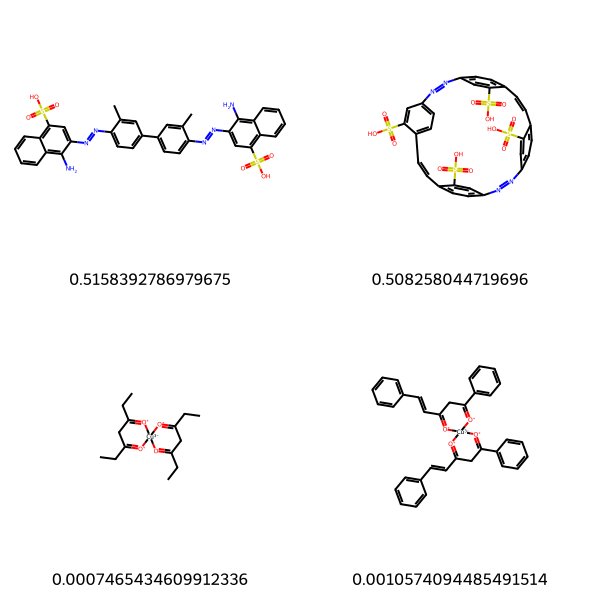

In [127]:
molecules = [Chem.MolFromSmiles(smiles) for smiles in smiles_data]

# Display molecules in a grid
img2 = Draw.MolsToGridImage(molecules, molsPerRow=2, subImgSize=(300, 300), legends=(prob_list_for_smile_data), maxMols=4)

img2

## Probabilities on their activity based on the smile structure. These 4 were spot on


In [ ]:
### END